In [2]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../../stimuli")

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
# import importlib
# import scoring

sys.path.append("../../stimuli/towers/block_utils/")
import blockworld_utils as utils

In [3]:
WORKER_ID, TRIAL_TYPE, TRIAL_INDEX, CONDITION, STIM_URL, RESPONSES = \
"workerID", "trial_type", "trial_index", "condition", "stimURL", "responses"
CONFIG_NAME = "config_name"

In [4]:
results_csv_directory = "../../results/csv"

# df_house = pd.read_csv(os.path.join(results_csv_directory, 'lax-structures-house-corpus-pilot_0.csv'))
df_trial = pd.read_csv(os.path.join(results_csv_directory, 'lax_corpus_1k_trial.csv'))

In [5]:
df_trial.loc[:, 'responses'] = df_trial.responses.apply(ast.literal_eval) # needed when reading from csv

### RT

<AxesSubplot:xlabel='domain', ylabel='rt_mins'>

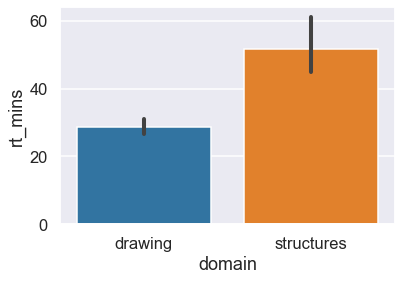

In [6]:
# people took longer in the structures domain

df_rt_sum = df_trial[df_trial.complete_dataset].groupby(['domain','subdomain','gameID']).sum().reset_index()
df_rt_sum.loc[:,'rt_mins'] = df_rt_sum.rt/60000
sns.barplot(data=df_rt_sum, x='domain', y='rt_mins')

Text(0.5, 1.0, 'rt and character count')

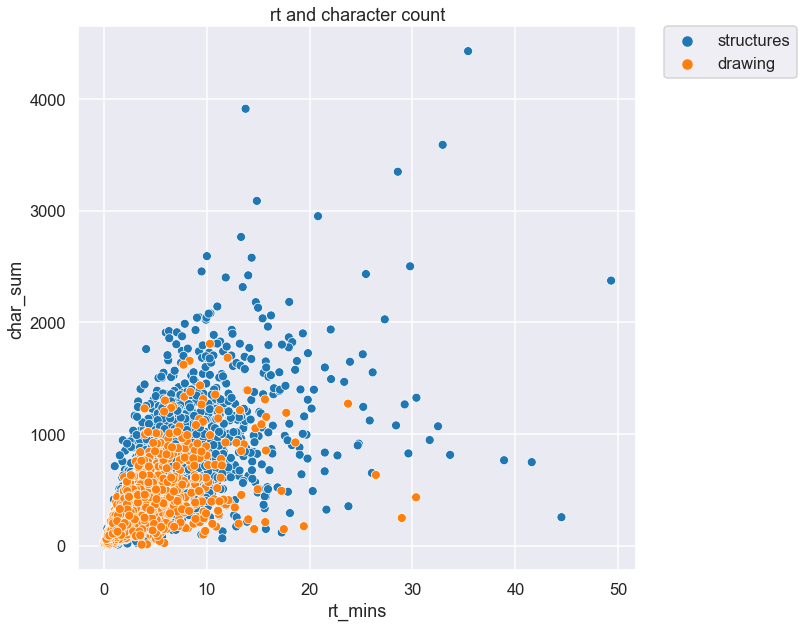

In [8]:
# longer reaction times in general mean longer responses

fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df_trial[(df_trial.trial_num>0) & 
                              (df_trial.rt_mins < 1000)], # remove outlier
                x='rt_mins', 
                hue='domain', 
                y='char_sum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('rt and character count')

### number of steps

In [9]:
df_tmp = df_trial[(df_trial.stimId != 'demo_stim') & 
                  (df_trial.complete_dataset)]


df_tmp.iterationName.unique()

array(['corpus_prolific_test', 'corpus_prolific_test_3'], dtype=object)

Text(0.5, 1.0, 'number of steps, before removing participants who hit 8-step limit')

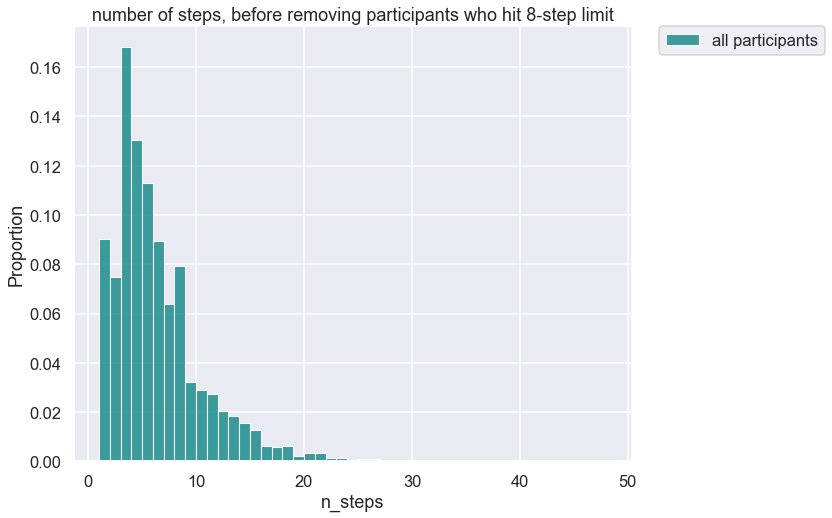

In [11]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_tmp, x="n_steps", color="teal", label="all participants", binwidth=1,stat='proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps, before removing participants who hit 8-step limit')

Text(0.5, 1.0, 'number of steps, before removing participants who hit 8-step limit')

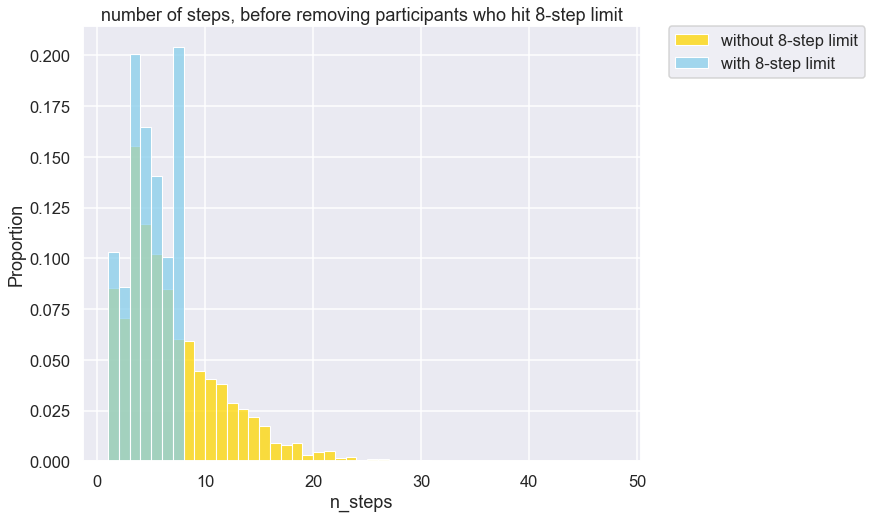

In [12]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_tmp[df_tmp.iterationName=='corpus_prolific_test_3'], 
             x="n_steps", color="gold", 
             label="without 8-step limit",
             binwidth=1,
             stat='proportion')
sns.histplot(data=df_tmp[df_tmp.iterationName=='corpus_prolific_test'], 
             x="n_steps", 
             color="skyblue",
             label="with 8-step limit", 
             binwidth=1,
             stat='proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps, before removing participants who hit 8-step limit')

Text(0.5, 1.0, 'number of steps, participants who hit 8-step limit removed')

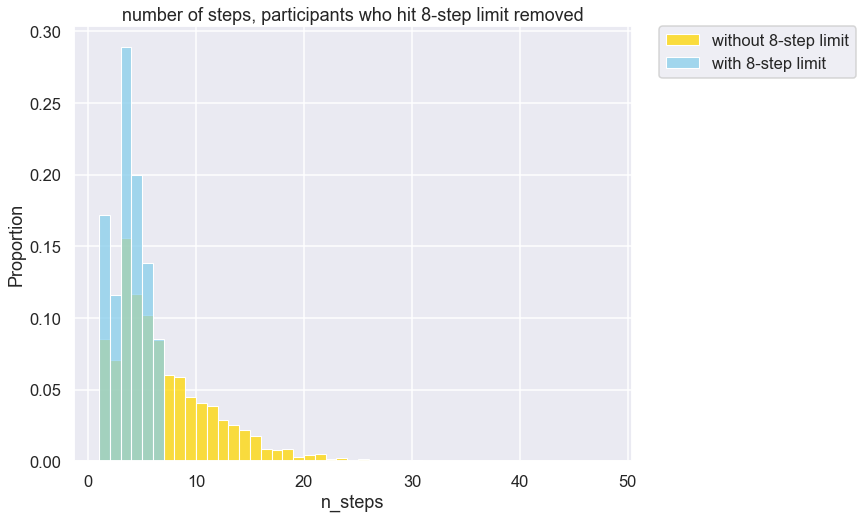

In [13]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_tmp[(df_tmp.iterationName=='corpus_prolific_test_3') & 
                         (~(df_tmp.ppt_hit_8_step_limit))], 
             x="n_steps", 
             color="gold", 
             label="without 8-step limit", 
             binwidth=1,
             stat='proportion')

sns.histplot(data=df_tmp[(df_tmp.iterationName=='corpus_prolific_test') & 
                         (~(df_tmp.ppt_hit_8_step_limit))], 
             x="n_steps",
             color="skyblue", 
             label="with 8-step limit", 
             binwidth=1,
             stat='proportion')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps, participants who hit 8-step limit removed')


<AxesSubplot:xlabel='n_steps', ylabel='Count'>

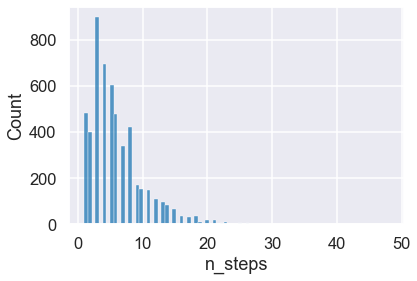

In [154]:
sns.histplot(df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)].n_steps)

Text(0.5, 1.0, 'number of steps, participants who hit 8-step limit removed')

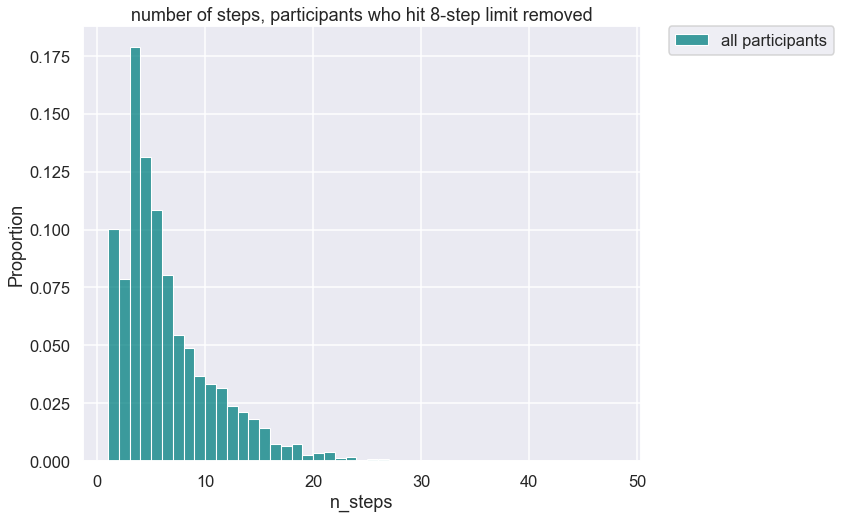

In [14]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_tmp[(~(df_tmp.ppt_hit_8_step_limit))], 
             x="n_steps", color="teal", label="all participants", binwidth=1, stat='proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps, participants who hit 8-step limit removed')

Text(0.5, 1.0, 'number of steps across trials')

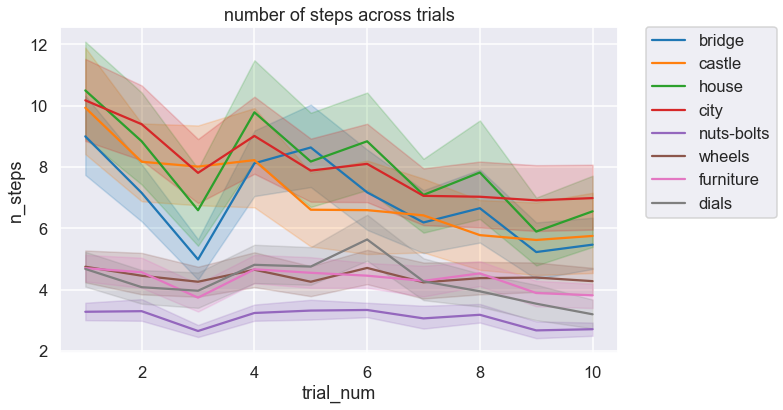

In [209]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset) &
                          ~(df_trial.ppt_hit_8_step_limit)],
             x='trial_num',
             y='n_steps',
             hue='subdomain')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps across trials, by subdomain')

Text(0.5, 1.0, 'number of steps across trials, by domain')

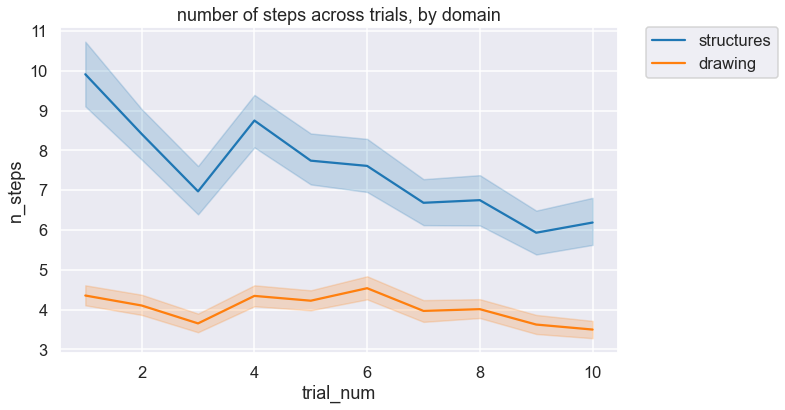

In [216]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset) &
                          ~(df_trial.ppt_hit_8_step_limit)],
             x='trial_num',
             y='n_steps',
             hue='domain')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('number of steps across trials, by domain')

### number of characters

Text(0.5, 1.0, 'total characters across trials, by domain')

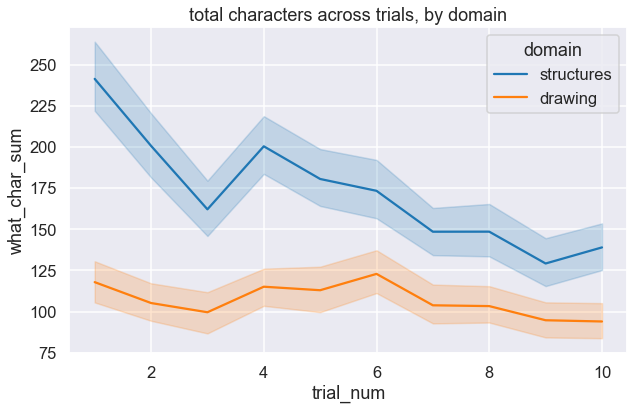

In [213]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], x='trial_num', y='what_char_sum', hue='domain')
             #, hue='gameid')
plt.title('total characters across trials, by domain')

Text(0.5, 1.0, 'total characters across trials, what vs. where, by domain')

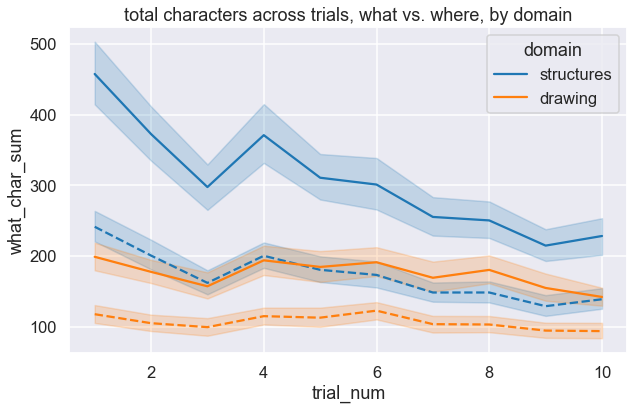

In [227]:
plt.figure(figsize=(10,6))

sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num',
             y='what_char_sum', 
             hue='domain', 
             linestyle='--')

sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num', y='where_char_sum', 
             hue='domain', 
             linestyle='-', 
             legend=False)
plt.title('total characters across trials, what vs. where, by domain')

Text(0.5, 1.0, 'total characters across trials, by subdomain')

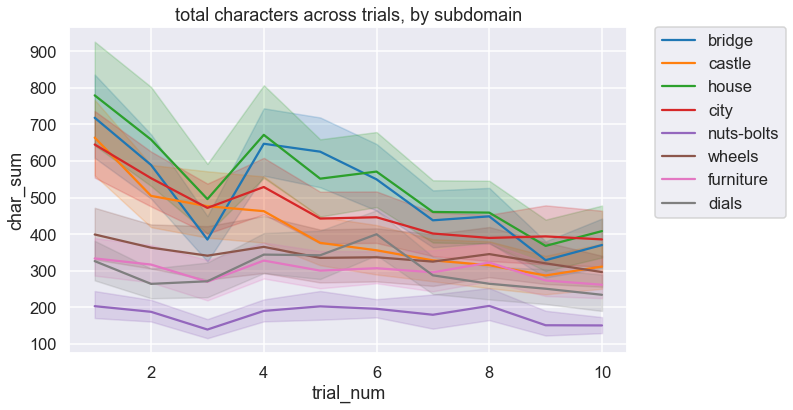

In [230]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[(df_trial.stimId != 'demo_stim') & 
                           (df_trial.complete_dataset)], 
             x='trial_num', 
             y='char_sum', 
             hue='subdomain')
             #, hue='gameid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters across trials, by subdomain')

In [331]:
df_trial['what_content'] = df_trial.whats.apply(ast.literal_eval)
df_trial['what_content'] = df_trial['what_content'].apply(lambda xs:" ".join(xs))

In [332]:
df_trial['what_content'] = df_trial['what_content'].str.lower()
df_trial['what_content'] = df_trial['what_content'].str.replace(r'~', '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r'\(', '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r'\)', '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r'\,', '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r"\'", '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r"\:", '')
df_trial['what_content'] = df_trial['what_content'].str.replace(r"\;", '')

<ipython-input-332-ae60ebf15864>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trial['what_content'] = df_trial['what_content'].str.replace(r'\(', '')
<ipython-input-332-ae60ebf15864>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trial['what_content'] = df_trial['what_content'].str.replace(r'\)', '')
<ipython-input-332-ae60ebf15864>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trial['what_content'] = df_trial['what_content'].str.replace(r'\,', '')
<ipython-input-332-ae60ebf15864>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trial['what_content'] = df_trial['what_content'].str.replace(r"\'", '')
<ipython-input-332-ae60ebf15864>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_trial['what_content'] = df_trial['wha

In [396]:
df_whats = df_trial.groupby(['domain'])['what_content'].apply(lambda x: ' '.join(x)).reset_index()
df_whats['word_freq'] = df_whats['what_content'].apply(lambda x: Counter(x.split()))
df_whats['word_freq'] = df_whats['word_freq'].apply(lambda xs: {k: v for k, v in sorted(xs.items(), key=lambda item: item[1])})




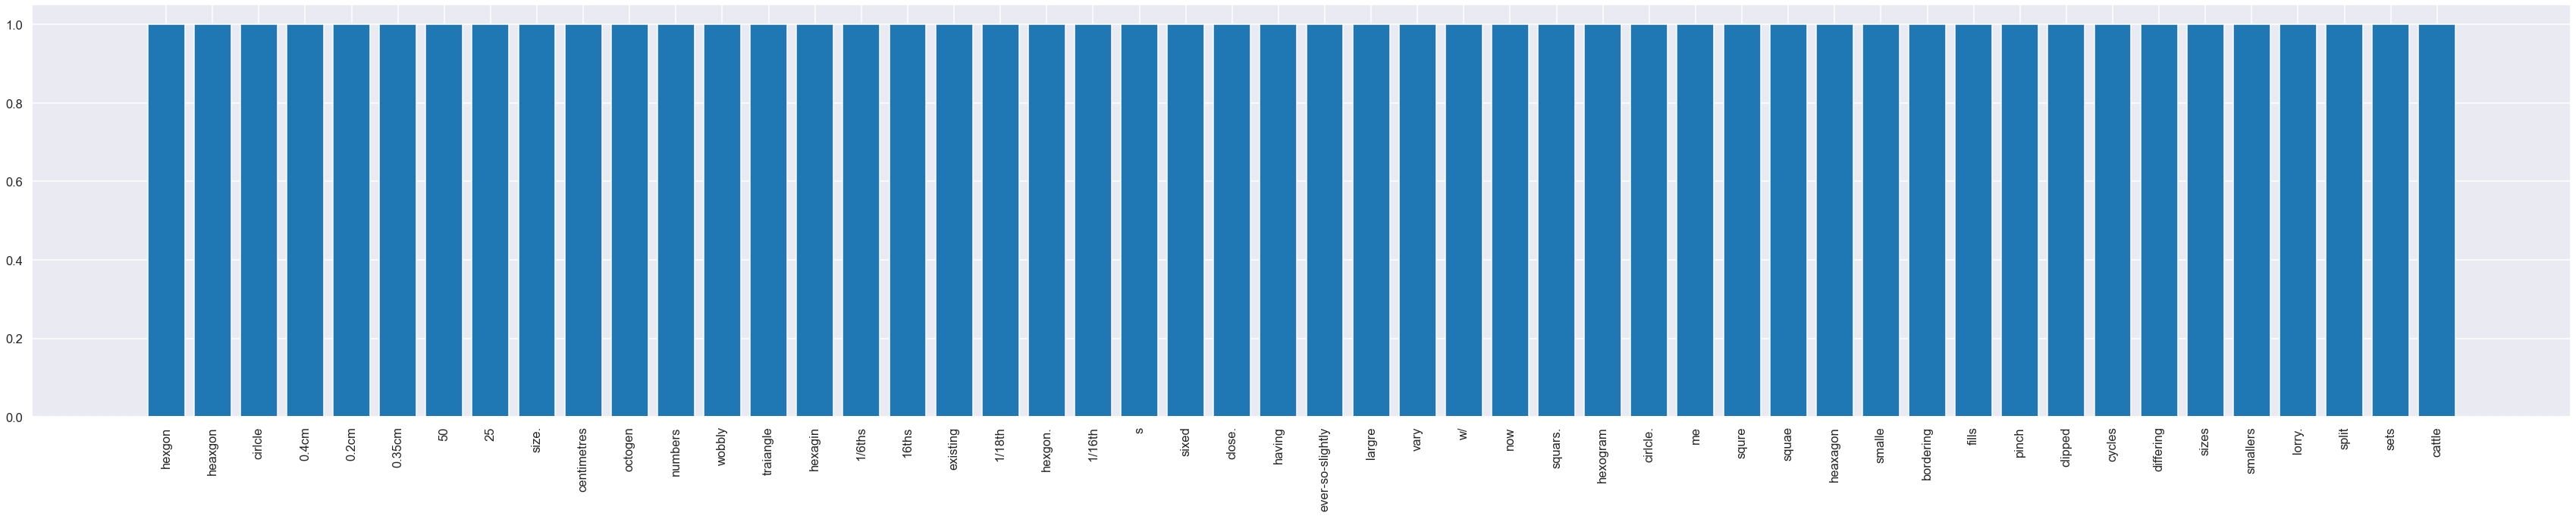

In [398]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = list(df_whats[df_whats.domain=='drawing']['word_freq'].iloc[0].keys())[0:50], 
      height= list(df_whats[df_whats.domain=='drawing']['word_freq'].iloc[0].values())[0:50])
# ax.bar(x = list(stds[domains[0]].keys()), height= [stds[domains[1]][w] for w in list(stds[0].keys())], fc=(0, 0.5, 0.5, 0.5))
_ = plt.xticks(rotation='vertical')
# plt.savefig('words.pdf')

In [391]:
list(df_whats[df_whats.domain=='drawing']['word_freq'].iloc[0].keys())

['a',
 'triangle',
 'square',
 'small',
 'hexagon',
 'larger',
 'smaller',
 'double',
 'edged',
 'tiny',
 'circle',
 '4',
 'circles',
 'more',
 '2',
 'squares',
 'octagon',
 'creating',
 'like',
 'shape',
 'without',
 'the',
 'side',
 'lines',
 'sqaure',
 '8',
 'slightly',
 'even',
 'half',
 'sized',
 'four',
 'five',
 'eight',
 'big',
 'two',
 'hexgon',
 'medium',
 'thick',
 'lined',
 'heaxgon',
 'cirlcle',
 'i',
 'will',
 'draw',
 '3',
 'to',
 'form',
 'equal',
 'equilateral',
 'and',
 'join',
 'them',
 '6',
 'circle.',
 'sided',
 'equally',
 '1cm',
 'radius',
 '2cm',
 '0.5cm',
 '0.1cm',
 'each',
 'per',
 '0.9cm',
 '0.4cm',
 '0.2cm',
 '0.35cm',
 '20',
 'percent',
 'in',
 'size',
 'medium-sized',
 'same',
 'orientation',
 'very',
 'one',
 'line',
 'another',
 'separate',
 'second',
 'third',
 'fourth',
 'large',
 'almost',
 'of',
 'first',
 'six',
 '50',
 'over',
 'an',
 'add',
 'close',
 'concentric',
 'hexagons',
 '25',
 'with',
 'exact',
 'size.',
 'distant',
 '15',
 'straight',
 '

In [390]:
df_whats[df_whats.domain=='drawing']['word_freq']

0    {'a': 3603, 'triangle': 259, 'square': 1136, '...
Name: word_freq, dtype: object

In [373]:
# Get word frequency distributions for all ppts
df_whats = df_trial.groupby(['domain','gameID'])['what_content'].apply(lambda x: ' '.join(x)).reset_index()
df_whats['word_freq'] = df_whats['what_content'].apply(lambda x: Counter(x.split()))
df_whats.head()

,domain,gameID,what_content,word_freq
0,drawing,0041-2edd4628-a7d5-4521-b7c2-139accf19230,an equilateral triangle medium sized a perfect...,"{'an': 1, 'equilateral': 1, 'triangle': 2, 'me..."
1,drawing,0070-d5495cd4-a977-485f-8eee-dbe738fb52d3,triangle small square vertical line 2/3 height...,"{'triangle': 1, 'small': 16, 'square': 3, 'ver..."
2,drawing,0124-71ffc537-1014-4b6d-8120-ba4819c7cbf5,triangle square rectangle rectangle vertical l...,"{'triangle': 1, 'square': 1, 'rectangle': 16, ..."
3,drawing,0125-454ab101-6273-4424-8f68-bd994fcf3ba1,a triangle a square the same size a rectangle ...,"{'a': 34, 'triangle': 1, 'square': 5, 'the': 4..."
4,drawing,0147-3cc2326a-3831-4fd0-a5d2-3090e58e3dc6,triangle square rectangle rectangle square squ...,"{'triangle': 1, 'square': 15, 'rectangle': 33,..."


In [374]:
# create support
split_words = df_whats['what_content'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [375]:
df_whats['word_pdist'] = df_whats.apply(get_pdist, axis = 1)
df_whats['word_pdist_numeric'] = df_whats['word_pdist'].apply(lambda dist: list(dist.values()))

In [376]:
domains = df_trial.domain.unique()

In [377]:
stds = {}

for domain in domains:
    stds[domain] = {}
    w_probs = {}

    for w in all_words:
        w_probs[w] = list(df_whats[df_whats.domain==domain]['word_pdist'].apply(lambda probs: probs[w]))

    for w in all_words:    
        stds[domain][w] = np.std(w_probs[w])
        
    stds[domain] = {k: v for k, v in sorted(stds[domain].items(), key=lambda item: item[1])}

In [378]:
stds[domain][w]

2.0679515313825692e-25

In [379]:
stds[domain]

{'blue': 2.0679515313825692e-25,
 'red': 2.0679515313825692e-25,
 'layer': 2.0679515313825692e-25,
 'pyramid': 2.0679515313825692e-25,
 'following': 2.0679515313825692e-25,
 '4/3/4/3/2/1': 2.0679515313825692e-25,
 'diamond': 2.0679515313825692e-25,
 '2/3/4/3/2/1': 2.0679515313825692e-25,
 'x4': 2.0679515313825692e-25,
 'layered': 2.0679515313825692e-25,
 '2/1/2/1': 2.0679515313825692e-25,
 '4/3/2/1': 2.0679515313825692e-25,
 'structures': 2.0679515313825692e-25,
 '1/2/1/2/1/2/1': 2.0679515313825692e-25,
 '4x2': 2.0679515313825692e-25,
 '3/2/1': 2.0679515313825692e-25,
 '1/2/1/2/1/2': 2.0679515313825692e-25,
 'mix': 2.0679515313825692e-25,
 '2/1': 2.0679515313825692e-25,
 'strucutre': 2.0679515313825692e-25,
 '8x': 2.0679515313825692e-25,
 'format': 2.0679515313825692e-25,
 '2x2+1': 2.0679515313825692e-25,
 '1x': 2.0679515313825692e-25,
 '2/2/3/2/1': 2.0679515313825692e-25,
 '1/2/1': 2.0679515313825692e-25,
 'blue/4x': 2.0679515313825692e-25,
 'vertical/2x': 2.0679515313825692e-25,
 '2x

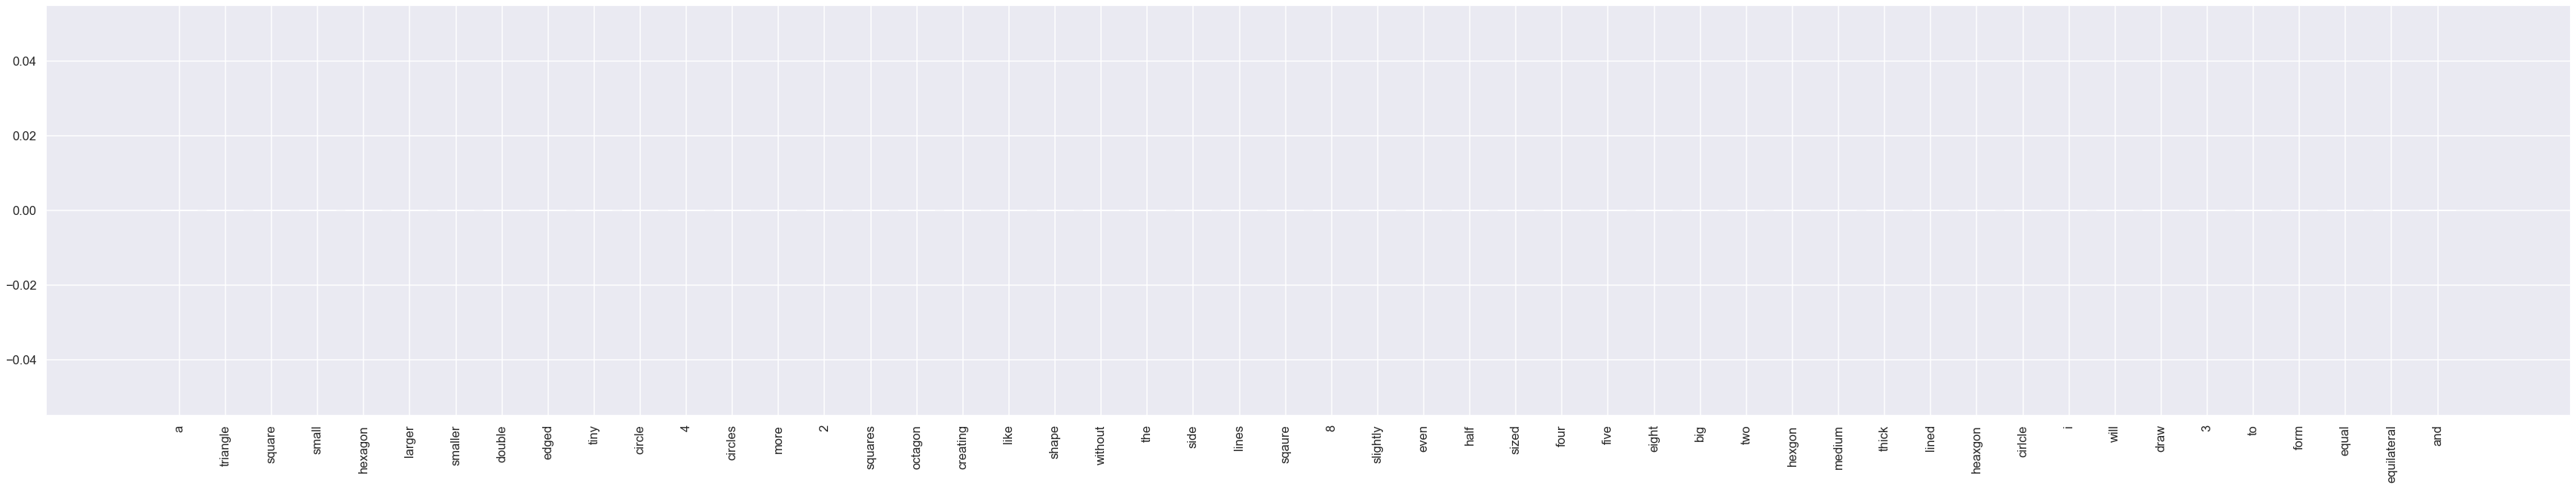

In [361]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = list(stds[domains[0]].keys())[0:50], height= list(stds[domains[0]].values())[0:50], fc=(1, 0.2, 0, 0.5))
# ax.bar(x = list(stds[domains[0]].keys()), height= [stds[domains[1]][w] for w in list(stds[0].keys())], fc=(0, 0.5, 0.5, 0.5))
_ = plt.xticks(rotation='vertical')
# plt.savefig('words.pdf')